#### Helper Code

This code runs out of the box on Google Colab. It is also the recommended way to run this notebook if you do not already have an environment with Python 3 and TensorFlow already set up.

In [0]:
import numpy as np
import os

matplotlib_style = "ggplot"
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')

from IPython.core.pylabtools import figsize
notebook_screen_res = "retina"
%config InlineBackend.figure_format = notebook_screen_res

from IPython.display import clear_output

In [2]:
import tensorflow as tf
try:
    tf.enable_eager_execution()
    print("Enabled eager execution")
except Exception as e:
    print(e)
    print("Eager execution:", tf.executing_eagerly() )
    

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

print("TensorFlow\t\t", ":", tf.__version__)
print("TensorFlow Probability\t", ":", tfp.__version__)

from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
print("Devices:")
print([x.name for x in local_device_protos])

Enabled eager execution

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

TensorFlow		 : 1.13.1
TensorFlow Probability	 : 0.6.0
Devices:
['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']


In [0]:
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    return tf.contrib.framework.nest.pack_sequence_as(tensors,
                                                      [t.numpy() if tf.contrib.framework.is_tensor(t) else t
                                                       for t in tf.contrib.framework.nest.flatten(tensors)])

In [0]:
def beta_expectation(alpha, beta):
    return alpha/(alpha+beta)

def beta_variance(alpha, beta):
    numerator = alpha*beta
    denominator = (alpha+beta+1) * ((alpha+beta)**2)
    return numerator/denominator

# 03. Bayesian Approach and Coin-flip

## Bayesian Approach

Bayesians interpret a probability as measure of belief, or confidence, of an event occurring. Bayesian inference differs from more traditional statistical inference by preserving uncertainty. In other words, it returns a *distribution* instead of a scalar value.

We can ask a Bayesian function "Often my code has bugs. My code passed all $X$ tests; is my code bug-free?"

Notice that the Bayesian function accepts an additional argument: "Often my code has bugs". This parameter is the **prior**. By including the prior parameter, we are telling the Bayesian function to include our belief about the situation.

Let us denote $N$ as the number of instances of evidence we possess. As we gather an infinite amount of evidence, say as $N→∞,$ our Bayesian results (often) align with [frequentist](https://en.wikipedia.org/wiki/Frequentist_inference) results. Hence for large $N$, statistical inference is more or less objective. On the other hand, for small $N$, inference is much more unstable: frequentist estimates have more variance and larger confidence intervals. This is where Bayesian analysis excels.

By introducing a prior, and returning probabilities (instead of a scalar estimate), we preserve the uncertainty that reflects the instability of statistical inference of a small $N$ dataset.

## Coin-flip Example

Suppose, that you are unsure about the probability of success (heads) in a coin flip. You believe there is some true underlying ratio, call it $p$, but have no prior opinion on what $p$ might be.

We begin to flip a coin, and record the observations: either $H$ (heads/success) or $T$ (tails/failure). This is our **observed data**.

How our inference changes as we observe more and more data? More specifically, what do our **posterior** probabilities look like when we have little data, versus when we have lots of data.

We define a **Bernoulli Random Variable** `rv_coin_flip_prior` that describes the probability of success of a **coin flip**. `rv_coin_flip_prior` follows a **Bernoulli distribution** with:

* success rate parameter $p$
* expectation E[$X$] = $p$
* var($X$) = $p(1-p)$



In [0]:
rv_coin_flip_prior = tfp.distributions.Bernoulli(probs=0.5,
                                                 dtype=tf.int32)

After performing the experiment with $N$ = `num_trial` trials, we have a observation vector `coin_flip_data` and observed parameter $\theta$

In [6]:
num_trials = tf.constant(range(201))

coin_flip_data = rv_coin_flip_prior.sample(num_trials[-1])
print("Observation vector, x =")
print(coin_flip_data.numpy(), "of size", len(coin_flip_data.numpy()))

Observation vector, x =
[1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1
 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0
 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0
 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0
 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0
 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1] of size 200


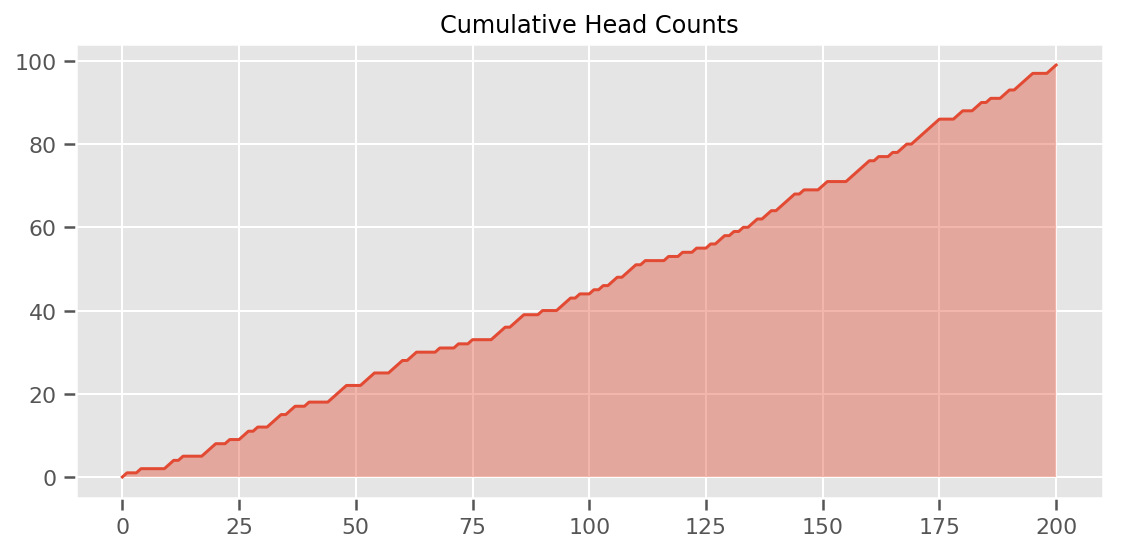

In [7]:
# first (zeroth) coin flip is always a failure (tails)
coin_flip_data = tf.pad(coin_flip_data,tf.constant([[1, 0,]]),"CONSTANT")

# compute cumulative headcounts from 0 to 2000 flips
# then grab them at each of num_trials intervals
cumulative_headcounts = tf.gather(tf.cumsum(coin_flip_data), num_trials)

plt.figure(figsize(8, 4))
plt.title("Cumulative Head Counts")
plt.plot(range(201),
         cumulative_headcounts)
plt.fill_between(range(201), 0, cumulative_headcounts, alpha=0.4)
plt.tight_layout()
plt.show()

Since $\theta$ is the parameter of a **Bernoulli RV**,  we know that $\theta$ exists in interval [0, 1]. The prior distribution is hence the uniform distribution on [0, 1], also a **Beta distribution** with parameters $\alpha_0=1$ and $\beta_0=1$.

A posterior distribution is the conditional distribution of the parameter $\theta$ given the data.

Sampling from the prior distribution `rv_coin_flip_prior`, we get a **posterior distribution** `rv_observed_heads` which follows a **Beta distribution** with hyperparameters $\alpha_1$ and $\beta_1$:

* $\alpha_1=\alpha_0$ + `num_success`
* $\beta_1=\beta_0$ + `num_trials` - `num_success`


In [8]:
rv_observed_heads = tfp.distributions.Beta(concentration1=tf.cast(1 + cumulative_headcounts, tf.float32),
                                           concentration0=tf.cast(1 + num_trials - cumulative_headcounts, tf.float32))

print("Posterior Distribution:")
print("rv_observed_heads", type(rv_observed_heads))

Posterior Distribution:
rv_observed_heads <class 'tensorflow_probability.python.distributions.beta.Beta'>


In [0]:
parameter_space = tf.linspace(start=0., stop=1., num=200, name="linspace")

# calculate values of posterior distribution
rv_coin_flip_posterior = rv_observed_heads.prob(parameter_space[:, tf.newaxis])

rv_coin_flip_posterior = tf.transpose(rv_coin_flip_posterior)

In [0]:
results_list = evaluate([num_trials,
                        parameter_space,
                        rv_coin_flip_posterior,
                        cumulative_headcounts])

[num_trials_, parameter_space_, rv_coin_flip_posterior_, cumulative_headcounts_,] = results_list

Below we plot a sequence of updating posterior probabilities as we observe increasing amounts of data (coin flips). The graph shows:

*  x-axis: parameter space of $p$ (probability of success)
*  y-axis: posterior distribution given data $x$

This gives us an indication of the probability that the "real" value of parameter $p$ is the observed value $\theta$.

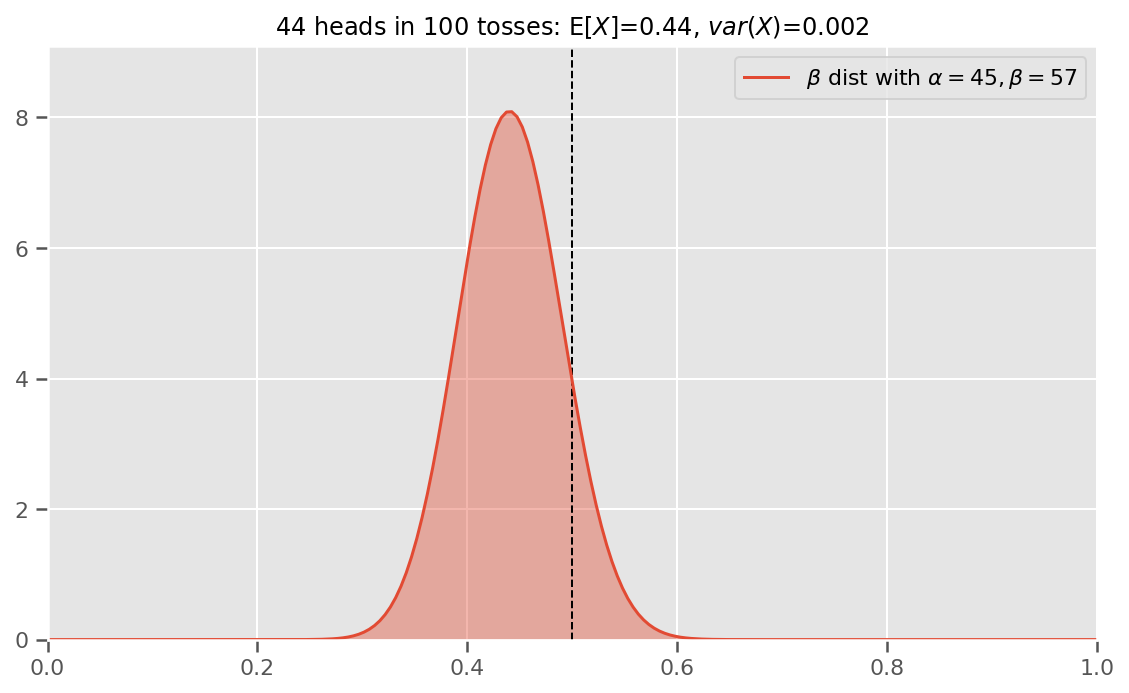

In [12]:
#@title Number of trials  { run: "auto" }
i = 100 #@param {type:"slider", min:1, max:200, step:1}

i = i

plt.figure(figsize(8, 5))

alpha = 1 + cumulative_headcounts_[i]
beta = 1 + num_trials_[i] - cumulative_headcounts_[i]
ex = round(beta_expectation(alpha, beta),2)
var = beta_variance(alpha, beta)
var = '{:g}'.format(float('{:.1g}'.format(var)))
title = r"%d heads in %d tosses"%(cumulative_headcounts_[i], num_trials_[i])
title = title + r": E[$X$]=" + str(ex) + ", $var(X)$=" + str(var)
legend = r"$\beta$ dist with $\alpha="+str(alpha)+r", \beta="+str(beta)+"$"

plt.plot(parameter_space_,         # x-axis is the parameter space of p
         rv_coin_flip_posterior_[i], # y-axis is Pr(P=p|x) 
         label=legend)
plt.fill_between(parameter_space_, 0, rv_coin_flip_posterior_[i], alpha=0.4)
plt.vlines(0.5, 0, max(4, max(rv_coin_flip_posterior_[i])+1),
           color="k", linestyles="--", lw=1)
leg = plt.legend()
leg.get_frame().set_alpha(0.8)
plt.autoscale(tight=True)
plt.title(title)
plt.tight_layout()
plt.show()

Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. This occurs earlier in the sequence (small $N$) is reduced as $N$ increases.

> **N is never large**
> 
> "Sample sizes are never large. If N is too small to get a sufficiently-precise estimate, you need to get more data (or make more assumptions). But once N is “large enough,” you can start subdividing the data to learn more (for example, in a public opinion poll, once you have a good estimate for the entire country, you can estimate among men and women, northerners and southerners, different age groups, etc etc). N is never enough because if it were “enough” you’d already be on to the next problem for which you need more data.
> 
> Similarly, you never have quite enough money. But that’s another story."
> 
> *Gelman, Andrew. N.p.. Web. 22 Jan 2013.* [N is never large enough](http://andrewgelman.com/2005/07/31/n_is_never_larg)


## References

1.   Chapter 1, [Probabilistic Programming & Bayesian Methods for Hackers](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
2.   Lecture 15, Introduction to Probability and Statistics, 50.034 (2018), Singapore University of Technology and Design

